In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from itertools import islice
import IPython.display as ipd
from pathlib import Path
import torch
import librosa
import numpy as np
import pandas as pd

In [3]:
from fastai import *
from fastai.conv_learner import *
from fastai.core import *
from fastai.metrics import accuracy, accuracy_np
from fastai.text import SortSampler, SortishSampler
from data_loading_utils import read_file
from preprocessing_utils import load_features
from helpers import *
from metrics import *
from models import *

In [4]:
from data_loading_utils import *

In [19]:
# PATH = Path('/data/audioset')

# TRAIN_PATH = PATH/'train_segments_mono'
# VALID_PATH = PATH/'eval_segments_mono'

# TRAIN_PATH_LMS = PATH/'train_22500_1024_256_128'
# VALID_PATH_LMS = PATH/'valid_22500_1024_256_128'

# TRAIN_LABELS_CSV = PATH/'train_segments_cl.csv'
# VALID_LABELS_CSV = PATH/'eval_segments_cl.csv'

# LABELS_CSV = PATH/'class_labels_indices.csv'

PATH = Path('../data/freesound')
TRAIN_PATH = PATH/'audio_train'
TRAIN_PATH_LMS = PATH/'audio_train_24000_1024_256_128'
# TRAIN_PATH_LMS_TFM = PATH/'audio_train_tfms_24000_1024_256_128'

TEST_PATH = PATH/'audio_test_24000'
TEST_PATH_LMS = PATH/'audio_test_24000_1024_256_128'

sample_rate = 24000
n_features = 128
n_fft = 1024
hop_length = 256

In [20]:
train_csv = pd.read_csv(PATH/'train.csv')
train_fname = train_csv.fname.values
test_csv = pd.read_csv(PATH/'sample_submission.csv')
test_fname = test_csv.fname.values

labels = sorted(train_csv.label.unique())
label_idx = {label:i for i, label in enumerate(labels)}

train_y = train_csv.label.apply(lambda l: label_idx[l]).values
test_y = np.zeros(len(test_fname))

len(train_fname), len(train_y), len(test_fname), len(test_y)
((val_fname, trn_fname), (val_y, trn_y)) = get_first_split(train_fname, train_y, 7)
(len(trn_fname), len(trn_y), len(val_fname), len(val_y))

(8108, 8108, 1365, 1365)

In [26]:
num_classes = len(labels)
opt = optim.Adam
metrics = [accuracy, mapk]
loss = F.cross_entropy

In [140]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    conv = nn.Conv2d(in_channels, 
                     out_channels,
                     kernel_size=kernel_size, 
                     stride=stride,
                     padding=padding, 
                     bias=False)
    batch_norm = nn.BatchNorm2d(out_channels, 
                                momentum=0.01)
    relu = nn.ReLU()
    return nn.Sequential(conv, batch_norm, relu)

class ResBlock(nn.Module):
    def __init__(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        self.conv = nn.Conv2d(in_channels, 
                         out_channels,
                         kernel_size=kernel_size, 
                         stride=stride,
                         padding=padding, 
                         bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels, 
                                    momentum=0.01)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.conv(x)
        out = residual + out
        out = self.batch_norm(out)
        out = self.relu(out)
        return out

class AudioCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        layers = [Lambda(lambda x: x.view(x.shape[0], 1, x.shape[1], x.shape[2]))]

        # B1 to B5
        in_channels = 1
        num_filters = [16, 32, 64, 128, 256]
        for out_channels in num_filters:
            layers += [conv_block(in_channels,  out_channels, kernel_size=3, padding=1),
                       conv_block(out_channels, out_channels, kernel_size=3, padding=1),
                       nn.MaxPool2d(2, ceil_mode=True)]
            in_channels = out_channels
        
        # B6
        layers += [conv_block(256, 512, kernel_size=3, padding=1)] #  nn.MaxPool2d(2)]
        
        # F1
        layers += [conv_block(512, 1024, kernel_size=2, padding=1)]
        
        # F2
        #layers += [conv_block(1024, n_classes, kernel_size=1, padding=0)]
        layers += [
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            #nn.Dropout(0.1),
            nn.Linear(1024, n_classes),
            nn.Sigmoid() # added
        ]
                
        self.layers = nn.Sequential(*layers)
        self.n_classes = n_classes
        
    def forward(self, x):
        return self.layers(x)

In [42]:
stats = (-40.813029, 20.376415)
# stats = (-38.22718543505675, 20.197361411601136)

norm = Normalize(*stats)

# Commenting these transforms out because I didn't use them in the training data, because John said the tfms
# were not every effective anyway. So didn't want to slow down training for little gain.
# shift = RandomPitchTimeShift(min_x=1.0, max_x=1.0, max_y=1.2)
# light = RandomLight()

trn_tfms = Transforms([norm])
val_tfms = Transforms([norm])

In [192]:
bs = 16

trn_ds = AudioFilesDataset(TRAIN_PATH_LMS, train_fname, train_y, transform=trn_tfms)
trn_dl = AudioDataLoader2d(trn_ds,
                           batch_size=bs,
                           sampler=SortishSampler(trn_ds, key=lambda x: trn_ds[x][0].shape[1], bs=bs))

val_ds = AudioFilesDataset(TRAIN_PATH_LMS, val_fname, val_y, transform=val_tfms)
val_dl = AudioDataLoader2d(val_ds,
                           batch_size=bs,
                           sampler=SortSampler(val_ds, key=lambda x: val_ds[x][0].shape[1]))

test_ds = AudioFilesDataset(TEST_PATH_LMS, test_fname, test_y, transform=val_tfms)
test_dl = AudioDataLoader2d(test_ds, batch_size=1)

### Audioset Pretrained Model

In [44]:
num_classes = 41

In [162]:
def load_up_pretrained_audioset_model():
    num_audioset_classes = 527
    md = ModelData(PATH, trn_dl, val_dl)
    model = AudioCNN(num_audioset_classes).cuda()
    learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)
    learn.load_cycle('Audioset_CNN_1024_256_128_modified', 50)
    return model, learn

def adjust_model_for_freesound(audio_set_model, num_classes):
    backbone = nn.Sequential(*list(list(audio_set_model.children())[0].children())[:-4])
    head = nn.Sequential(
        nn.Dropout2d(0.25),
        # Expects 1024 as final conv dim. Need to add padding for ocassionally very small inputs
        nn.Conv2d(1024, num_classes, 3, padding=3),
        Lambda(lambda x: x.view(x.shape[0], num_classes, -1)),
        Lambda(lambda x: torch.mean(x, dim=2))
    )
    return nn.Sequential(
        backbone,
        head
    ).cuda()

def get_freesound_learner(model):
    md = ModelData(PATH, trn_dl, val_dl)
    return ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)

def finetune(learner, lr=10e-3, cycle_len=1, use_clr_beta=None):
    # Freezes all but the head
    learner.freeze()
    backbone = learner.get_layer_groups()[0]
    # Sets the final conv layer of the backbone to be trainable
    set_trainable(list(backbone.children())[-1], True)
    clr_params = use_clr_beta and (5, 20, 0.95, 0.75)
    learner.fit(lr, 1, cycle_len=cycle_len, use_clr_beta=clr_params)

In [163]:
audio_set_model, audio_set_learn = load_up_pretrained_audioset_model()

In [164]:
freesound_model = adjust_model_for_freesound(audio_set_model, num_classes)

In [165]:
freesound_learner = get_freesound_learner(freesound_model)

In [119]:
freesound_learner.lr_find()

 90%|█████████ | 535/593 [02:26<00:15,  3.65it/s, loss=11.4]

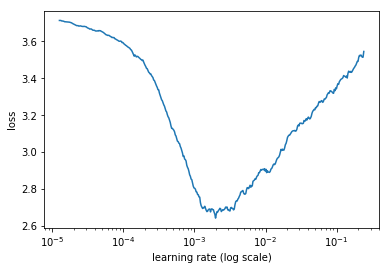

In [120]:
freesound_learner.sched.plot(n_skip_end=100)

In [144]:
finetune(freesound_learner)

  0%|          | 0/593 [00:00<?, ?it/s]
epoch      trn_loss   val_loss   accuracy   mapk            
    0      2.028317   1.48351    0.641758   0.726862  



In [166]:
finetune(freesound_learner, cycle_len=30, use_clr_beta=True)
freesound_learner.save_cycle('24khz_1024_256_128_modified_fully_conv_finetuned', 30)

  0%|          | 0/593 [00:00<?, ?it/s]                    
epoch      trn_loss   val_loss   accuracy   mapk            
    0      1.518239   1.594478   0.559707   0.685592  
    1      1.250057   1.179241   0.671795   0.768132        
    2      1.185066   0.979988   0.736264   0.815873         
    3      1.041432   1.011147   0.730403   0.811111         
    4      0.962101   0.892179   0.778755   0.844811         
    5      0.990273   0.931104   0.755311   0.834554         
    6      0.879901   0.813216   0.782418   0.849817         
    7      0.960853   0.86406    0.765568   0.840171         
    8      0.935433   0.796336   0.783883   0.853968         
    9      0.901636   0.712105   0.8        0.864591         
    10     0.870364   0.881411   0.759707   0.836142         
    11     0.779832   0.95971    0.72967    0.823199         
    12     0.670197   0.71104    0.787546   0.859096         
    13     0.662962   0.676018   0.812454   0.876557         
    14     0.5469  

In [176]:
freesound_learner.data.test_dl = test_dl

In [ ]:
freesound_learner

In [179]:
def get_submission(learner, filename="finetuned1"):
    model_preds = learner.predict_with_targs(is_test=True)[0]
    top_3 = np.array(labels)[np.argsort(-model_preds, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test_csv.label = predicted_labels
    test_csv.to_csv('24k_1024_256_128_' + filename + '.csv', index=False)
    return test_csv

In [180]:
test_csv = get_submission(freesound_learner)

In [182]:
test_csv.head(20)

,fname,label
0,00063640.wav,Cowbell Computer_keyboard Trumpet
1,0013a1db.wav,Violin_or_fiddle Flute Cowbell
2,002bb878.wav,Bass_drum Fireworks Gunshot_or_gunfire
3,002d392d.wav,Double_bass Bass_drum Cello
4,00326aa9.wav,Oboe Clarinet Flute
5,0038a046.wav,Knock Bass_drum Burping_or_eructation
6,003995fa.wav,Squeak Fireworks Flute
7,005ae625.wav,Gong Acoustic_guitar Electric_piano
8,007759c4.wav,Clarinet Flute Bark
9,008afd93.wav,Saxophone Clarinet Flute


In [183]:
def play_file(fname, path=TEST_PATH):
    fname = str(path/fname)
    print("playing", fname)
    return ipd.Audio(filename=fname, autoplay=True)

In [195]:
play_file('00d0ab77.wav')

playing ../data/freesound/audio_test_24000/00d0ab77.wav


In [196]:
len(test_csv)

9400